In [14]:
import jax
import jax.numpy as jnp
import numpy as np
import torch
import time
import pandas as pd

import optax

import matplotlib.pyplot as plt

import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.tools import sinkhorn_divergence
from ott import datasets
from ott.neural.methods import neuraldual
from ott.neural.networks import icnn
from ott.tools import plot

from IPython.display import clear_output, display

import ot
import ot as pot

import torchdyn
from torchdyn.core import NeuralODE

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *
from torchcfm.optimal_transport import OTPlanSampler

from src.sinkhorn_loss import sinkhorn_loss
from src.plotdataset import plot_dataset, just_plot
from src.mini_batch_ot import mini_batch, update_plan, compute_incomplete_plan

In [4]:
num_samples = 500
rng = jax.random.PRNGKey(0)

train_dataloaders, valid_dataloaders, input_dim, = datasets.create_gaussian_mixture_samplers(name_source="simple",
                                                                                             name_target="square_four",
                                                                                             train_batch_size=num_samples,
                                                                                             valid_batch_size=num_samples,
                                                                                             rng = rng
                                                                                             )

X = next(train_dataloaders.source_iter)
X_new = next(valid_dataloaders.source_iter)
Y = next(train_dataloaders.target_iter)
Y_new = next(valid_dataloaders.target_iter)

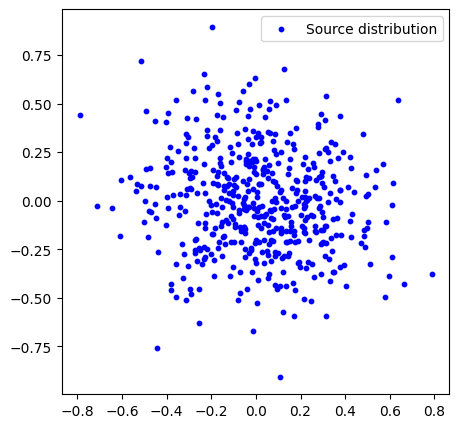

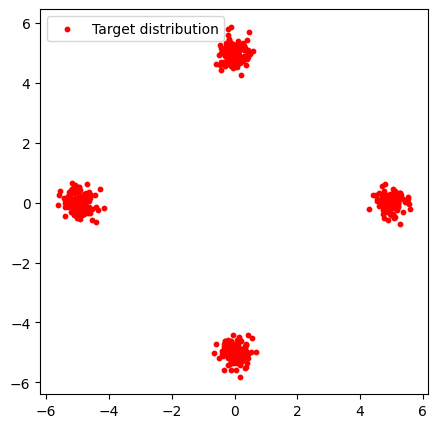

In [17]:
just_plot(X, label="Source distribution", color="blue")
just_plot(Y, label="Target distribution", color="red")

# Entropic Map

Sinkhorn distance - Entropic Map (reg=1): 4.04
Entropic dual distance (reg=1): 35.76
Entropic OT plan (reg:1)
Sinkhorn distance - Entropic Map (reg=10): 18.53
Entropic dual distance (reg=10): 149.13
Entropic OT plan (reg:10)
Sinkhorn distance - Entropic Map (reg=100): 24.34
Entropic dual distance (reg=100): 1268.05
Entropic OT plan (reg:100)


<Figure size 1200x500 with 0 Axes>

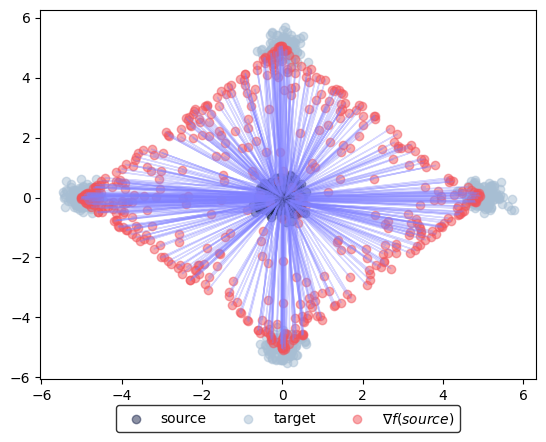

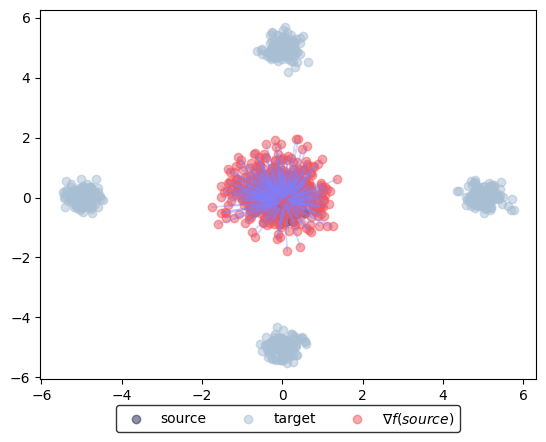

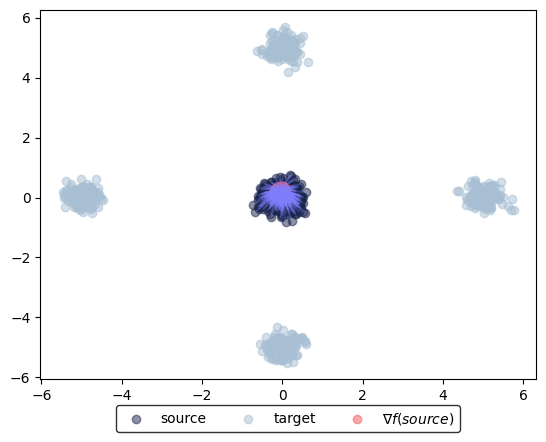

In [19]:
reg_list = [1, 10, 100]

plt.figure(3, figsize=(12, 5))

for i, reg in enumerate(reg_list):
    geom = ott.geometry.pointcloud.PointCloud(X, Y, epsilon = reg)    # Define an euclidean geometry
    problem = ott.problems.linear.linear_problem.LinearProblem(geom)  # Define your problem
    solver = ott.solvers.linear.sinkhorn.Sinkhorn()                   # Select the Sinkhorn solver

    out = solver(problem)                                             # Solve it !

    f = out.f                                                         # Get back the potentials f and g
    g = out.g

    # Define entropic map with the output of the solver
    entropic_map = out.to_dual_potentials()
    # Transport X with this map
    transported_samples_entropic = entropic_map.transport(X_new)
    # Compute Sinkhorn distance
    sinkhorn_div_entropic = sinkhorn_loss(transported_samples_entropic, Y_new)
    print(
        f"Sinkhorn distance - Entropic Map (reg={reg}): {sinkhorn_div_entropic:.2f}"
    )
    # Compute overall distance
    dist_entropic = entropic_map.distance(X_new, Y_new)
    print(
        f"Entropic dual distance (reg={reg}): {dist_entropic:.2f}"
    )
    print("Entropic OT plan (reg:{})".format(reg))
    entropic_map.plot_ot_map(X_new, Y_new)

plt.show()

# ICNN

In [7]:
def training_callback(step, learned_potentials):
    # Callback function as the training progresses to visualize the couplings.
    if step % 1000 == 0:
        clear_output()
        print(f"Training iteration: {step}/{num_train_iters}")

        fig, ax = learned_potentials.plot_ot_map(
            X_new,
            Y_new,
            forward=True,
        )
        display(fig)
        plt.close(fig)

        fig, ax = learned_potentials.plot_ot_map(
            X_new,
            Y_new,
            forward=False,
        )
        display(fig)
        plt.close(fig)

        fig, ax = learned_potentials.plot_potential()
        display(fig)
        plt.close(fig)

## Identity initialization method

In [49]:
# initialize optimizers
optimizer_f = optax.adam(learning_rate=1e-4, b1=0.5, b2=0.9, eps=1e-8)
optimizer_g = optax.adam(learning_rate=1e-4, b1=0.5, b2=0.9, eps=1e-8)

# initialize models using identity initialization (default)
neural_f = icnn.ICNN(dim_hidden=[64, 64, 64, 64], dim_data=2)
neural_g = icnn.ICNN(dim_hidden=[64, 64, 64, 64], dim_data=2)

# Select the Neural Dual solver
num_train_iters = 5000

neural_dual_solver = neuraldual.W2NeuralDual(
    input_dim,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    num_train_iters = num_train_iters
)

learned_potentials_identity = neural_dual_solver(*train_dataloaders, *valid_dataloaders, callback=training_callback)
clear_output()

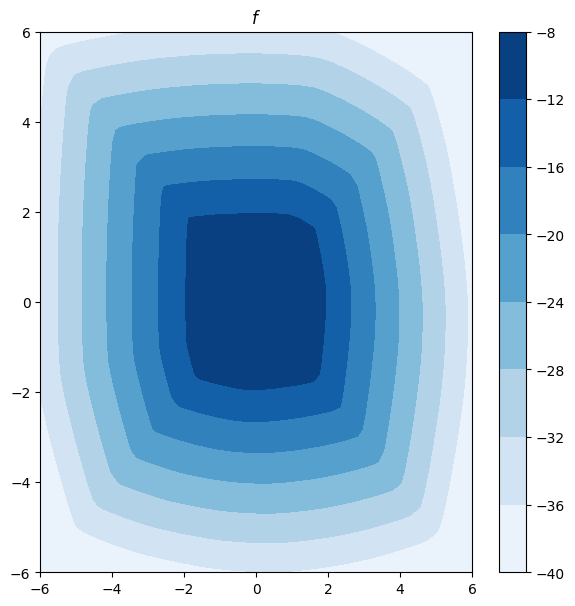

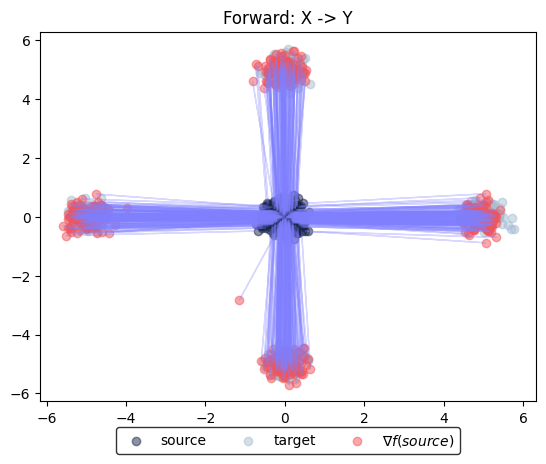

Sinkhorn distance between target predictions and data samples: 1.16
Neural dual distance between source and target data: 22.17


In [57]:
# Solve forward problem X -> Y
## Plot f potential
learned_potentials_identity.plot_potential(forward=True)
plt.show()

## Plot OT map
learned_potentials_identity.plot_ot_map(X_new, Y_new, forward=True)
plt.title("Forward: X -> Y")
plt.show()

transported_samples_forward = learned_potentials_identity.transport(X_new, forward = True)

## Compute Sinkhorn distance
sinkhorn_div_neural_forward = sinkhorn_loss(transported_samples_forward, Y_new)
print(
    f"Sinkhorn distance between target predictions and data samples: {sinkhorn_div_neural_forward:.2f}"
)
# Compute overall distance
neural_dual_dist = learned_potentials_identity.distance(X_new, Y_new)
print(
    f"Neural dual distance between source and target data: {neural_dual_dist:.2f}")

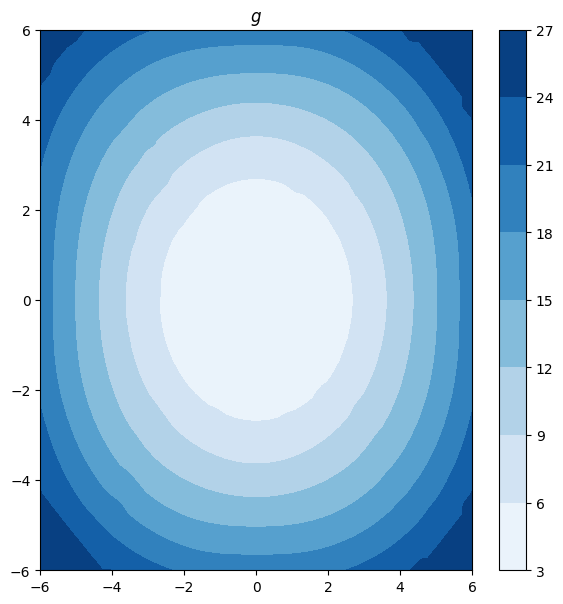

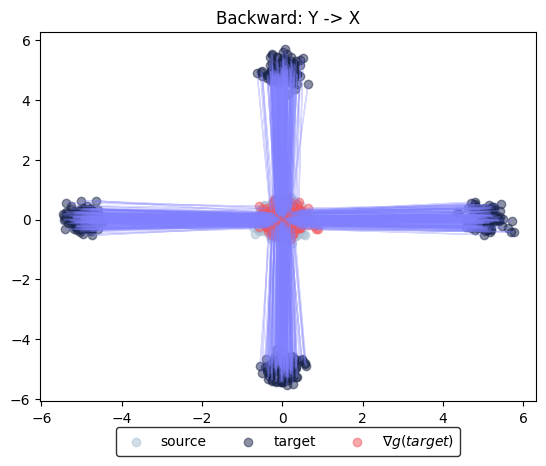

Sinkhorn distance between source predictions and data samples: 0.00


In [51]:
# Solve backward problem Y -> X
## Plot g potential
learned_potentials_identity.plot_potential(forward=False)
plt.show()

## Plot OT map
learned_potentials_identity.plot_ot_map(X_new, Y_new, forward=False)
plt.title("Backward: Y -> X")
plt.show()

transported_samples_backward = learned_potentials_identity.transport(Y_new, forward = False)

## Compute Sinkhorn distance
sinkhorn_div_neural_backward = sinkhorn_loss(transported_samples_backward, X_new)
print(
    f"Sinkhorn distance between source predictions and data samples: {sinkhorn_div_neural_backward:.2f}"
)

## Gaussian initialization

In [52]:
# initialize models using Gaussian initialization
neural_f = icnn.ICNN(
    dim_hidden=[64, 64, 64, 64],
    dim_data=2,
    gaussian_map_samples=(X, Y),
)
neural_g = icnn.ICNN(
    dim_hidden=[64, 64, 64, 64],
    dim_data=2,
    gaussian_map_samples=(Y, X),
)

# Select the Neural Dual solver
num_train_iters = 5000

neural_dual_solver = neuraldual.W2NeuralDual(
    input_dim,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    num_train_iters = num_train_iters
)

learned_potentials_gaussian = neural_dual_solver(*train_dataloaders, *valid_dataloaders, callback=training_callback)
clear_output()

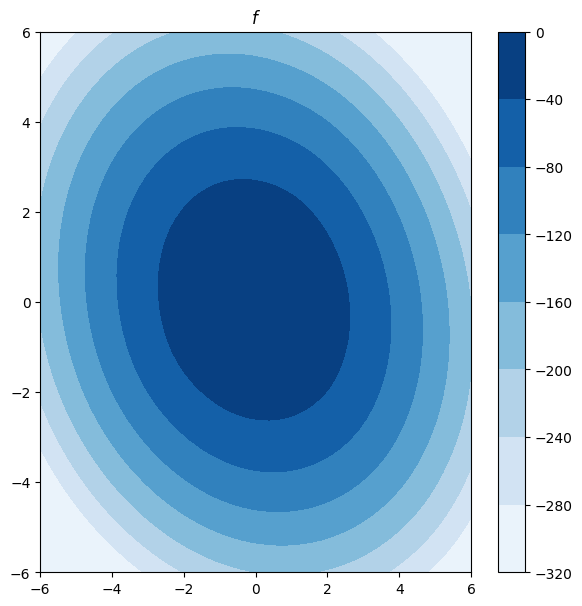

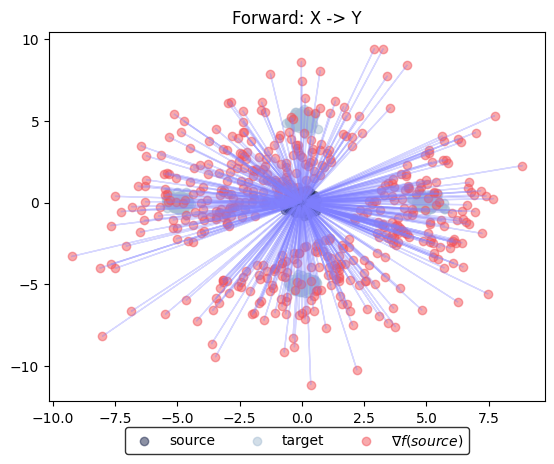

Sinkhorn distance between target predictions and data samples: 6.34
Neural dual distance between source and target data: 21.69


In [56]:
# Solve forward problem X -> Y
## Plot f potential
learned_potentials_gaussian.plot_potential(forward=True)
plt.show()

## Plot OT map
learned_potentials_gaussian.plot_ot_map(X_new, Y_new, forward=True)
plt.title("Forward: X -> Y")
plt.show()

transported_samples_forward = learned_potentials_gaussian.transport(X_new, forward = True)

## Compute Sinkhorn distance
sinkhorn_div_neural_forward = sinkhorn_loss(transported_samples_forward, Y_new)
print(
    f"Sinkhorn distance between target predictions and data samples: {sinkhorn_div_neural_forward:.2f}"
)
# Compute overall distance
neural_dual_dist = learned_potentials_gaussian.distance(X_new, Y_new)
print(
    f"Neural dual distance between source and target data: {neural_dual_dist:.2f}")

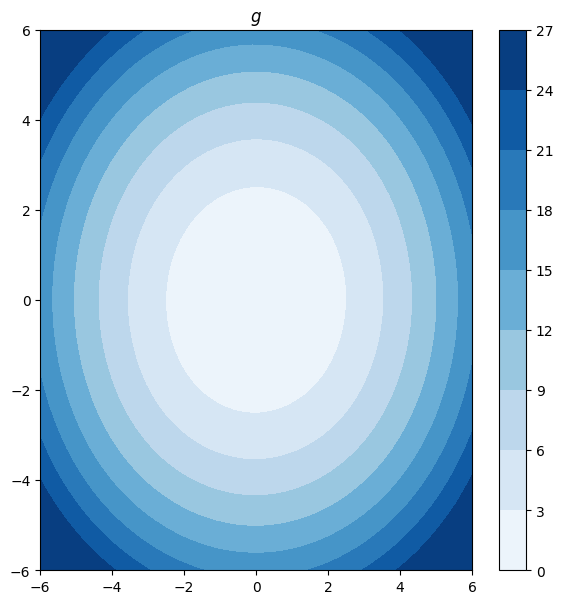

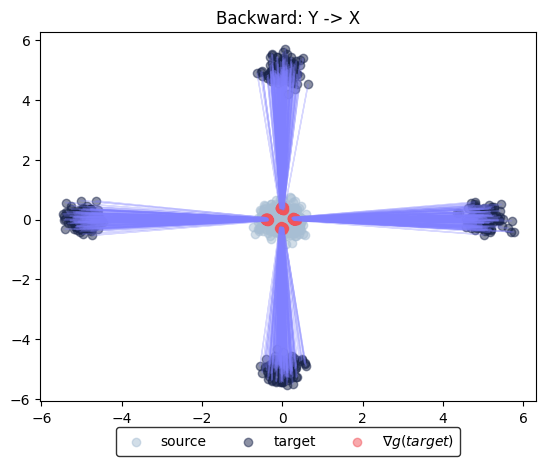

Sinkhorn distance between source predictions and data samples: 0.01


In [54]:
# Solve backward problem Y -> X
## Plot g potential
learned_potentials_gaussian.plot_potential(forward=False)
plt.show()

## Plot OT map
learned_potentials_gaussian.plot_ot_map(X_new, Y_new, forward=False)
plt.title("Backward: Y -> X")
plt.show()

transported_samples_backward = learned_potentials_gaussian.transport(Y_new, forward = False)

## Compute Sinkhorn distance
sinkhorn_div_neural_backward = sinkhorn_loss(transported_samples_backward, X_new)
print(
    f"Sinkhorn distance between source predictions and data samples: {sinkhorn_div_neural_backward:.2f}"
)

# Conditional Flow Matching

In [111]:
X_tensor = torch.from_numpy(np.asarray(X))
X_new_tensor = torch.from_numpy(np.asarray(X_new))
Y_tensor = torch.from_numpy(np.asarray(Y))
Y_new_tensor = torch.from_numpy(np.asarray(Y_new))

In [142]:
%%time
sigma = 0.1
dim = 2
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
FM = ConditionalFlowMatcher(sigma=sigma)
n_epochs = 5000

start = time.time()
for k in range(n_epochs):
  optimizer.zero_grad()

  t, xt, ut = FM.sample_location_and_conditional_flow(X_tensor, Y_tensor)
  vt = model(torch.cat([xt, t[:, None]], dim=-1))
  loss = torch.mean((vt - ut) ** 2)

  loss.backward()
  optimizer.step()

  if (k + 1) % 1000 == 0:
      end = time.time()
      print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
      start = end
      node = NeuralODE(
          torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
      )
      with torch.no_grad():
          traj = node.trajectory(
              X_new_tensor,
              t_span=torch.linspace(0, 1, 100),
          )
          plot_trajectories(traj.cpu().numpy())
clear_output()

CPU times: user 16 s, sys: 610 ms, total: 16.6 s
Wall time: 16.3 s


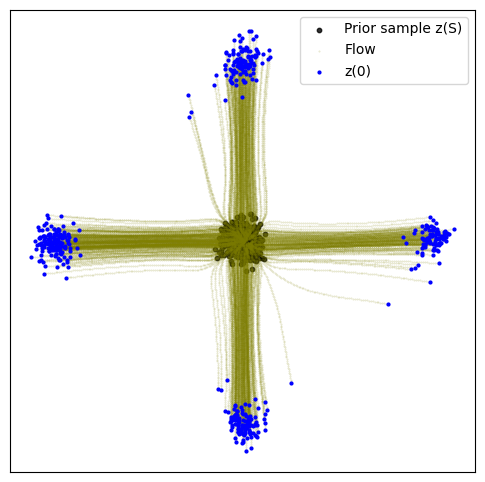

Sinkhorn distance between target predictions and data samples: 1.16


In [143]:
transported_samples_conditionnal_flow = node.trajectory(x=X_new_tensor, t_span=torch.linspace(0, 1, 100))

## Plot OT map
plot_trajectories(transported_samples_conditionnal_flow.detach().numpy())
## Compute Sinkhorn distance
sinkhorn_div_conditional_flow = sinkhorn_loss(jnp.array(transported_samples_conditionnal_flow[-1].detach().numpy()), Y_new)
print(
    f"Sinkhorn distance between target predictions and data samples: {sinkhorn_div_conditional_flow:.2f}"
)


# Optimal Transport flow matching

In [146]:
%%time
sigma = 0.1
dim = 2
ot_sampler = OTPlanSampler(method="exact")
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
FM = ConditionalFlowMatcher(sigma=sigma)
n_epochs = 5000

start = time.time()
for k in range(n_epochs):
  optimizer.zero_grad()
  x0, x1 = ot_sampler.sample_plan(X_tensor, Y_tensor) # Draw samples from OT plan

  t = torch.rand(x0.shape[0]).type_as(x0)
  xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
  ut = compute_conditional_vector_field(x0, x1)

  vt = model(torch.cat([xt, t[:, None]], dim=-1))
  loss = torch.mean((vt - ut) ** 2)

  loss.backward()
  optimizer.step()

  if (k + 1) % 1000 == 0:
      end = time.time()
      print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
      start = end
      node = NeuralODE(
          torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
      )
      with torch.no_grad():
          traj = node.trajectory(
              X_new_tensor,
              t_span=torch.linspace(0, 1, 100),
          )
          plot_trajectories(traj.cpu().numpy())
clear_output()

CPU times: user 4min, sys: 916 ms, total: 4min 1s
Wall time: 4min


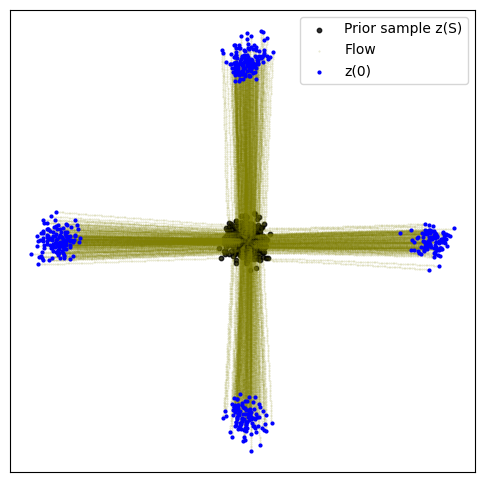

Sinkhorn distance between target predictions and data samples: 2.31


In [148]:
transported_samples_ot_flow = node.trajectory(x=X_new_tensor, t_span=torch.linspace(0, 1, 100))

## Plot OT map
plot_trajectories(transported_samples_ot_flow.detach().numpy())
## Compute Sinkhorn distance
sinkhorn_div_ot_flow = sinkhorn_loss(jnp.array(transported_samples_ot_flow[-1].detach().numpy()), Y_new)
print(
    f"Sinkhorn distance between target predictions and data samples: {sinkhorn_div_ot_flow:.2f}"
)


## Mini-batch OT

In [2]:
# We pre-compute the ground cost matrix
M = torch.cdist(X_tensor, Y_tensor) ** 2

ot_plan_list = []
num_iter = 5000
a, b = ot.unif(num_samples), ot.unif(num_samples)

ot_sampler = OTPlanSampler(method="exact")
pi = ot_sampler.get_map(X_tensor, Y_tensor)
ot_plan_list.append(pi)

# Compuete incomplete mbot plan for several batch sizes
batch_size_list = [128, 64]

for i, batch_size in enumerate(batch_size_list):
    incomplete_mbot_plan = compute_incomplete_plan(X_tensor, Y_tensor, a, b, batch_size, num_iter, M.numpy())
    ot_plan_list.append(incomplete_mbot_plan)

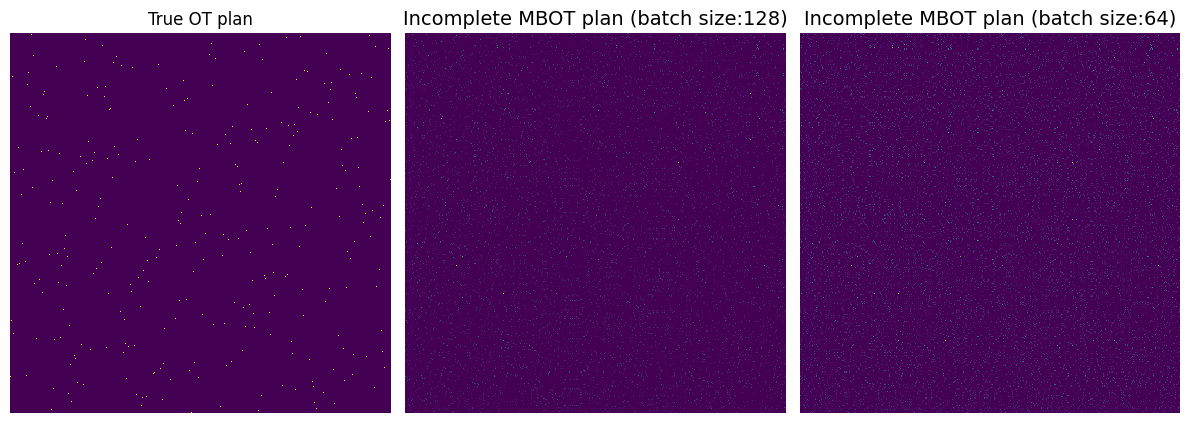

In [155]:
plt.figure(figsize=(12, 5))

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(ot_plan_list[i], interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title("True OT plan")
    else:
        batch_size = batch_size_list[i - 1]
        plt.title("Incomplete MBOT plan (batch size:{})".format(batch_size), fontsize=14)
    plt.tight_layout()

5000: loss 0.059 time 33.74
Sinkhorn distance - OT-CFM trained with true OT plan: 4.41
5000: loss 0.072 time 29.86
Sinkhorn distance - OT-CFM trained w. MBOT (size:128): 4.80
5000: loss 0.116 time 30.57
Sinkhorn distance - OT-CFM trained w. MBOT (size:128): 1.70
CPU times: user 1min 35s, sys: 542 ms, total: 1min 36s
Wall time: 1min 37s


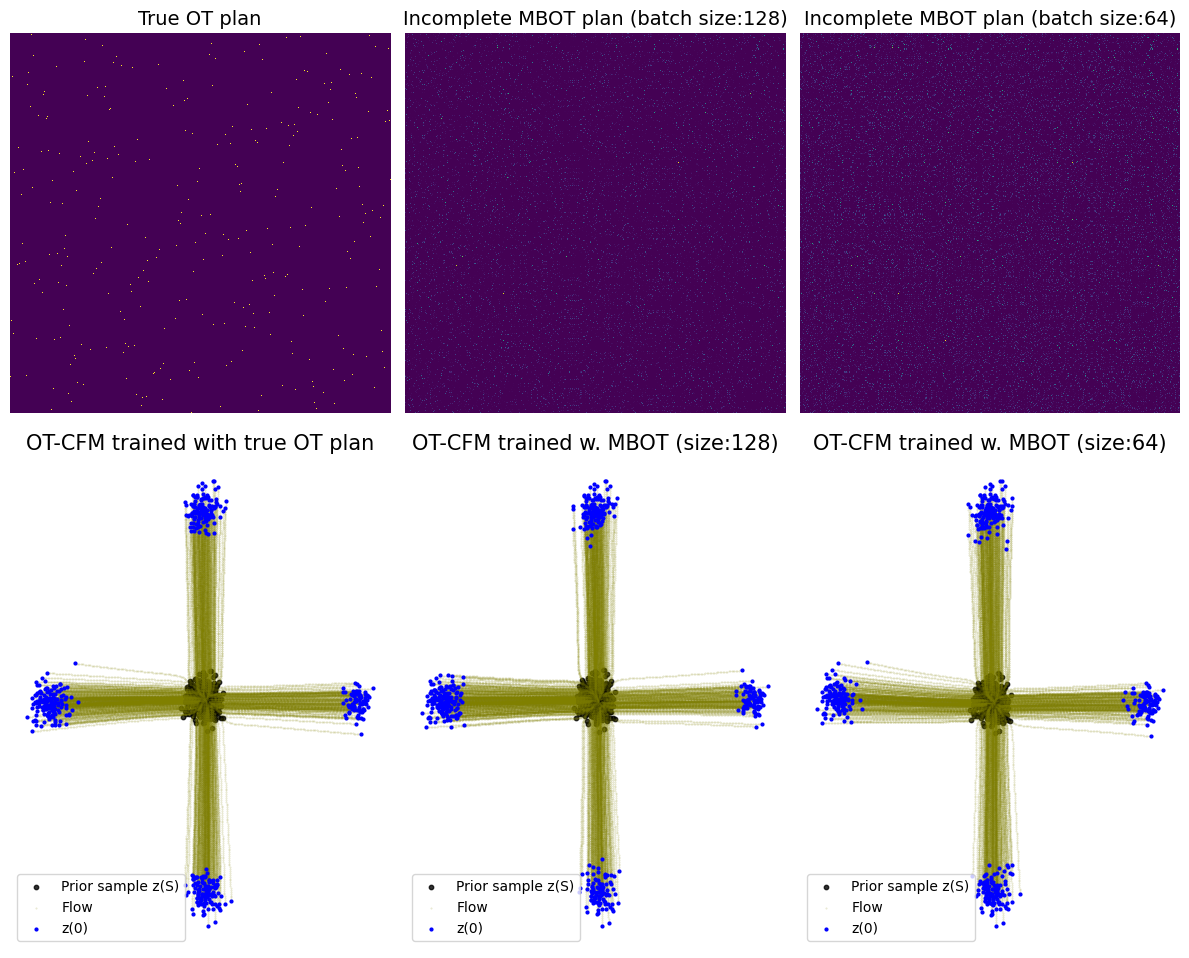

In [158]:
%%time
sigma = 0.1
dim = 2
plt.figure(3, figsize=(12, 10))
batch_size = 128
n_epochs = 5000

for i, mbot_plan in enumerate(ot_plan_list):
    model = MLP(dim=dim, time_varying=True)
    optimizer = torch.optim.Adam(model.parameters())
    FM = ConditionalFlowMatcher(sigma=sigma)

    ot_sampler = OTPlanSampler(method="exact")

    start = time.time()
    for k in range(n_epochs):
        optimizer.zero_grad()

        indices_i, indices_j = ot_sampler.sample_map(
            mbot_plan, batch_size=batch_size, replace=False
        )
        batch_x0, batch_x1 = X_tensor[indices_i], Y_tensor[indices_j]

        t, xt, ut = FM.sample_location_and_conditional_flow(batch_x0, batch_x1)

        vt = model(torch.cat([xt, t[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer.step()

    end = time.time()
    print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
    start = end
    node = NeuralODE(
        torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
    )
    with torch.no_grad():
        traj = node.trajectory(
            X_new_tensor,
            t_span=torch.linspace(0, 1, 100),
        )

        sinkhorn_div = sinkhorn_loss(jnp.array(traj[-1].detach().numpy()), Y_new)
        if i == 0:
          print(
              f"Sinkhorn distance - OT-CFM trained with true OT plan: {sinkhorn_div:.2f}"
          )
        else:
          print(
              f"Sinkhorn distance - OT-CFM trained w. MBOT (size:{batch_size}): {sinkhorn_div:.2f}"
          )
        plt.subplot(2, 3, i + 1)
        plt.imshow(ot_plan_list[i], interpolation="nearest")
        plt.axis("off")
        if i == 0:
            plt.title("True OT plan", fontsize=14)
        else:
            batch_size = batch_size_list[i - 1]
            plt.title("Incomplete MBOT plan (batch size:{})".format(batch_size), fontsize=14)

        plt.subplot(2, 3, i + 4)
        traj = traj.cpu().numpy()
        plt.scatter(
            traj[0, :num_samples, 0], traj[0, :num_samples, 1], s=10, alpha=0.8, c="black"
        )
        plt.scatter(
            traj[:, :num_samples, 0], traj[:, :num_samples, 1], s=0.2, alpha=0.2, c="olive"
        )
        plt.scatter(traj[-1, :num_samples, 0], traj[-1, :num_samples, 1], s=4, alpha=1, c="blue")
        plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
        plt.xticks([])
        plt.yticks([])
        plt.axis("off")
        if i == 0:
            plt.title("OT-CFM trained with true OT plan", fontsize=15)
        else:
            plt.title("OT-CFM trained w. MBOT (size:{})".format(batch_size), fontsize=15)
        plt.tight_layout()

# SB-CFM: OT-CFM trained with Entropic OT

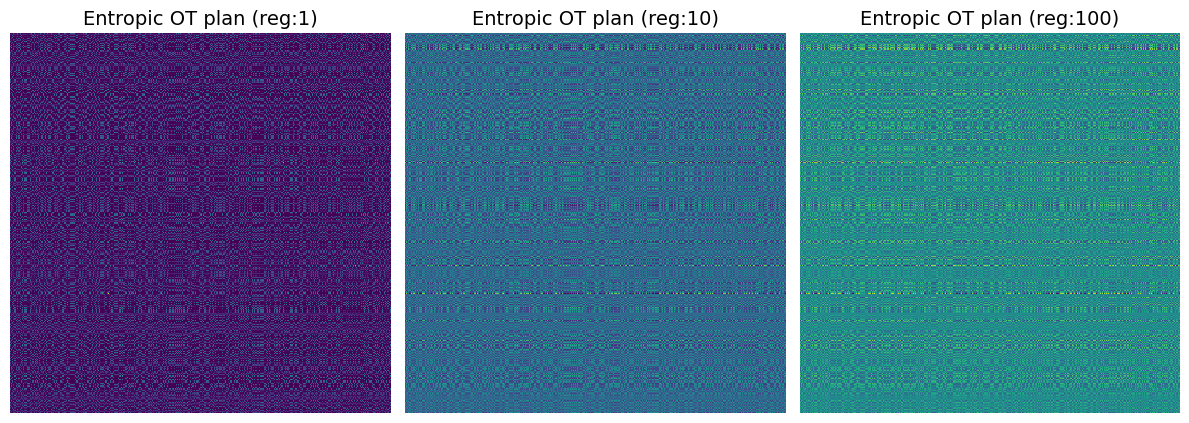

In [159]:
reg_list = [1, 10, 100]

plt.figure(3, figsize=(12, 5))

ot_plan_list = []

for i, reg in enumerate(reg_list):
    ot_sampler = OTPlanSampler(method="sinkhorn", reg=reg)

    entropic_ot_plan = ot_sampler.get_map(X_tensor, Y_tensor)
    ot_plan_list.append(entropic_ot_plan)
    plt.subplot(1, 3, i + 1)
    plt.imshow(entropic_ot_plan, interpolation="nearest")
    plt.axis("off")
    plt.title("Entropic OT plan (reg:{})".format(reg), fontsize=14)
    plt.tight_layout()

5000: loss 0.622 time 30.90
Sinkhorn distance - Entropic-OT plan (reg=1): 5.73
5000: loss 0.847 time 27.15
Sinkhorn distance - Entropic-OT plan (reg=10): 4.79
5000: loss 1.474 time 26.98
Sinkhorn distance - Entropic-OT plan (reg=100): 0.84
CPU times: user 1min 24s, sys: 840 ms, total: 1min 25s
Wall time: 1min 28s


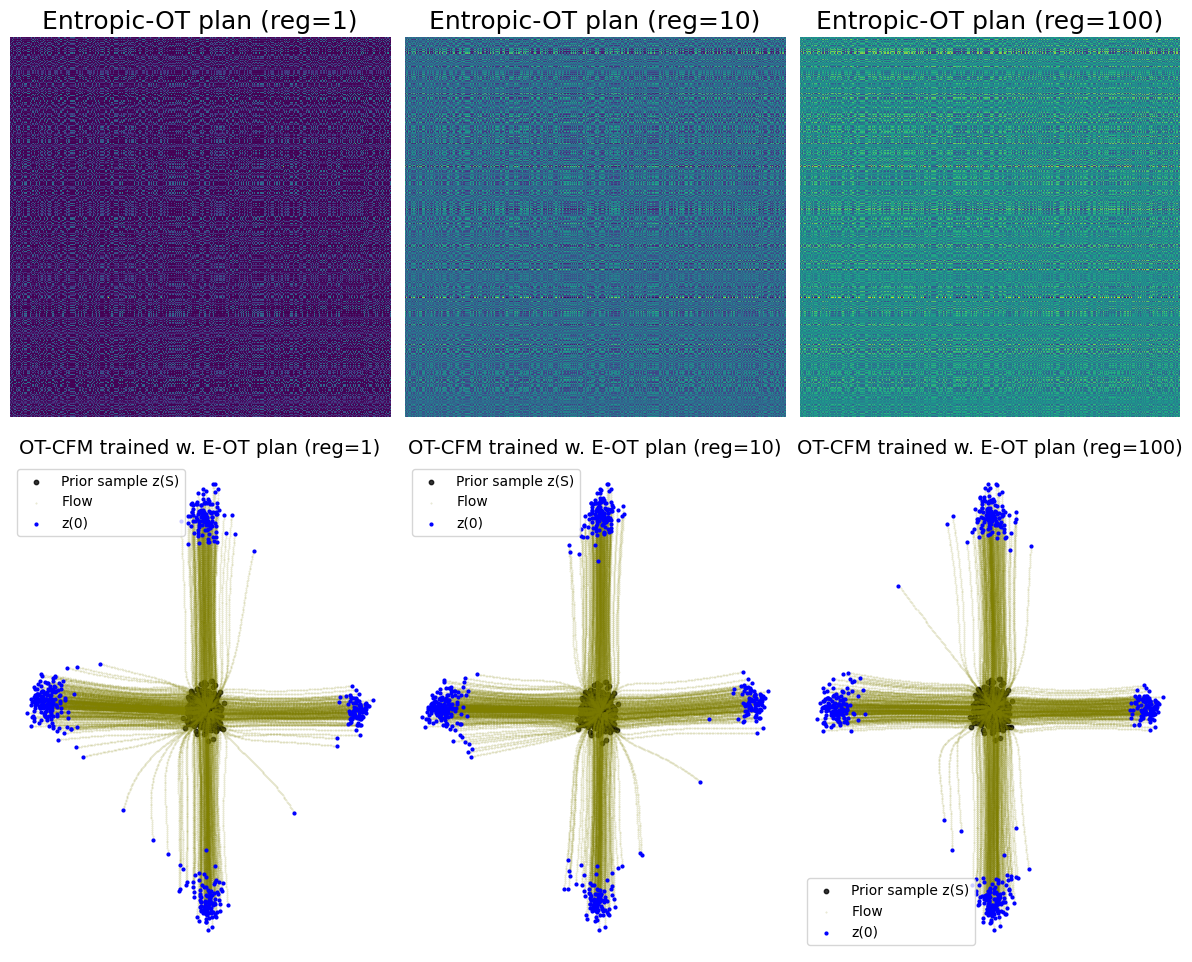

In [161]:
%%time
sigma = 0.1
dim = 2
batch_size = 128

plt.figure(3, figsize=(12, 10))

for i, reg in enumerate(reg_list):
    model = MLP(dim=dim, time_varying=True)
    optimizer = torch.optim.Adam(model.parameters())
    FM = ConditionalFlowMatcher(sigma=sigma)

    ot_sampler = OTPlanSampler(method="sinkhorn", reg=reg)

    pi = ot_sampler.get_map(X_tensor, Y_tensor)

    start = time.time()
    for k in range(n_epochs):
        optimizer.zero_grad()

        indices_i, indices_j = ot_sampler.sample_map(pi, batch_size=batch_size, replace=False)
        batch_x0, batch_x1 = X_tensor[indices_i], Y_tensor[indices_j]

        t, xt, ut = FM.sample_location_and_conditional_flow(batch_x0, batch_x1)

        vt = model(torch.cat([xt, t[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer.step()

    end = time.time()
    print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
    start = end
    node = NeuralODE(
        torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
    )
    with torch.no_grad():
        traj = node.trajectory(
            X_new_tensor,
            t_span=torch.linspace(0, 1, 100),
        )

        sinkhorn_div = sinkhorn_loss(jnp.array(traj[-1].detach().numpy()), Y_new)
        print(
              f"Sinkhorn distance - Entropic-OT plan (reg={reg}): {sinkhorn_div:.2f}"
          )

        plt.subplot(2, 3, i + 1)
        plt.imshow(ot_plan_list[i], interpolation="nearest")
        plt.axis("off")
        plt.title("Entropic-OT plan (reg={})".format(reg), fontsize=18)

        plt.subplot(2, 3, i + 4)
        traj = traj.cpu().numpy()
        plt.scatter(
            traj[0, :num_samples, 0], traj[0, :num_samples, 1], s=10, alpha=0.8, c="black"
        )
        plt.scatter(
            traj[:, :num_samples, 0], traj[:, :num_samples, 1], s=0.2, alpha=0.2, c="olive"
        )
        plt.scatter(traj[-1, :num_samples, 0], traj[-1, :num_samples, 1], s=4, alpha=1, c="blue")
        plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
        plt.xticks([])
        plt.yticks([])
        plt.axis("off")
        plt.title("OT-CFM trained w. E-OT plan (reg={})".format(reg), fontsize=14)
        plt.tight_layout()

# Run time Comparison

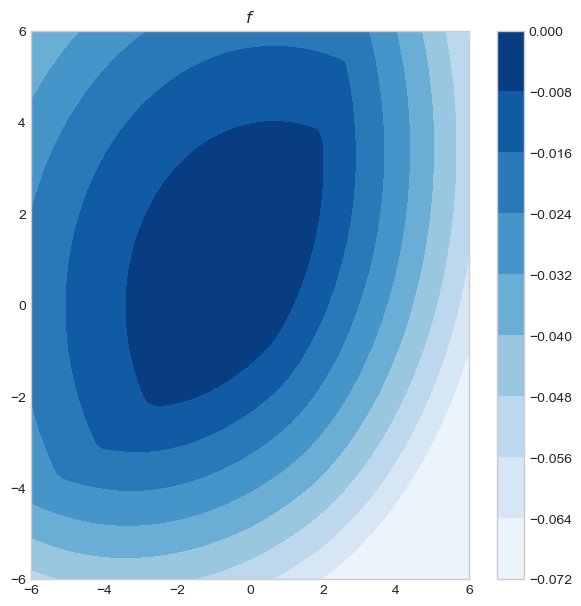

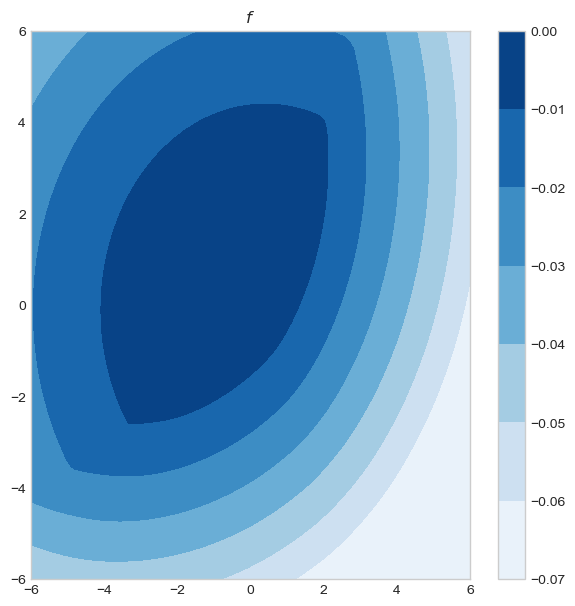

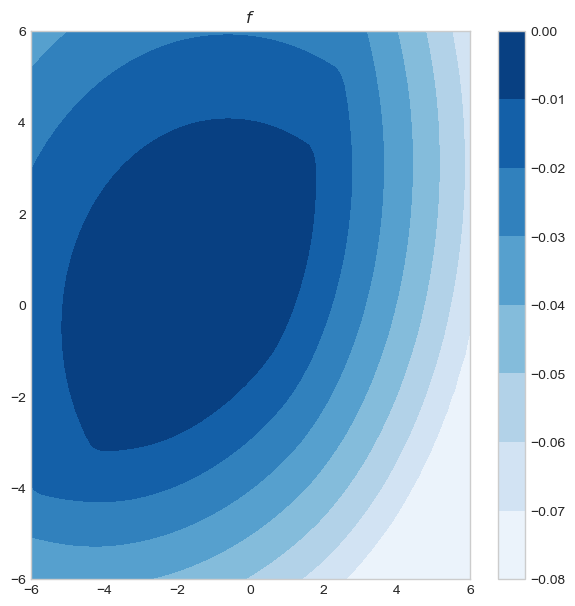

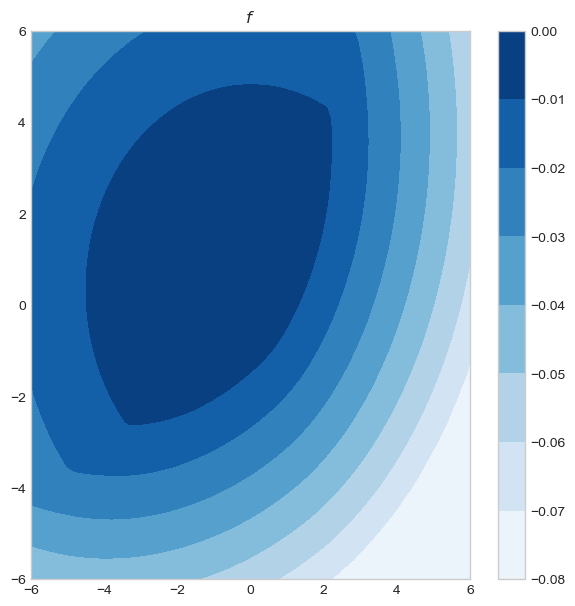

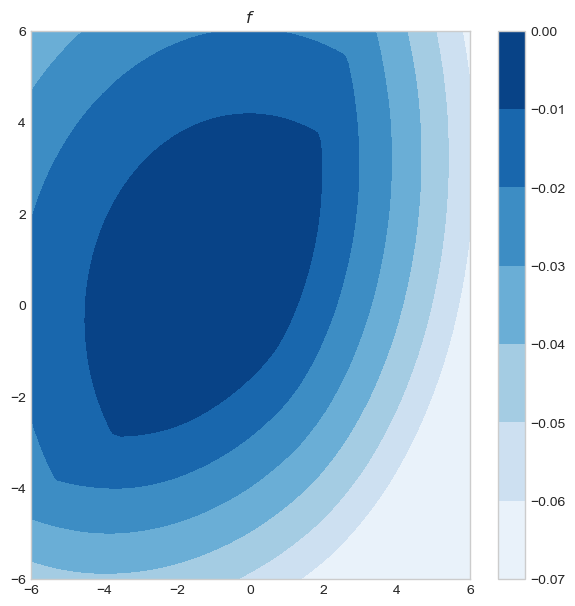

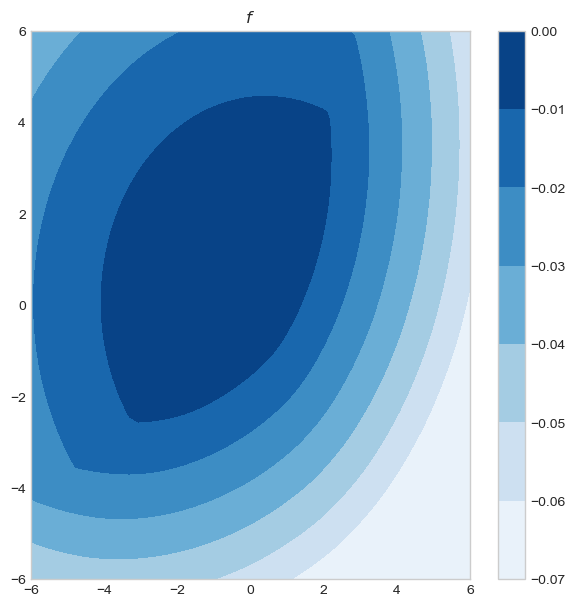

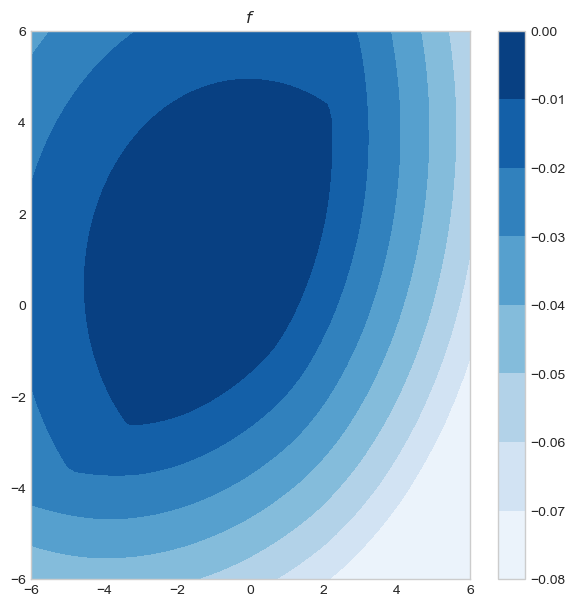

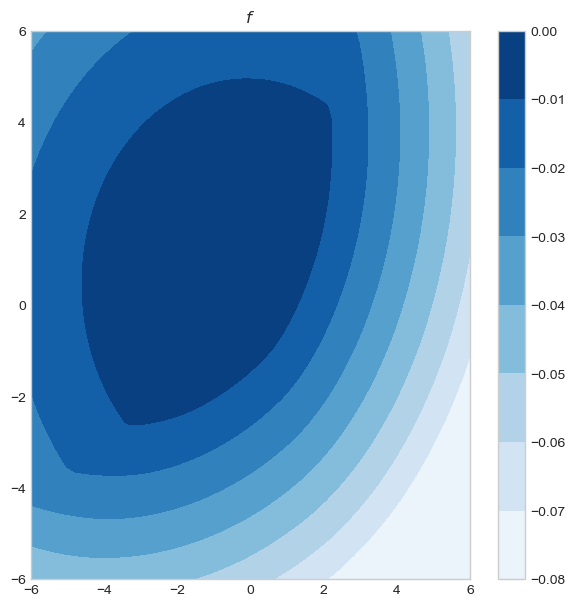

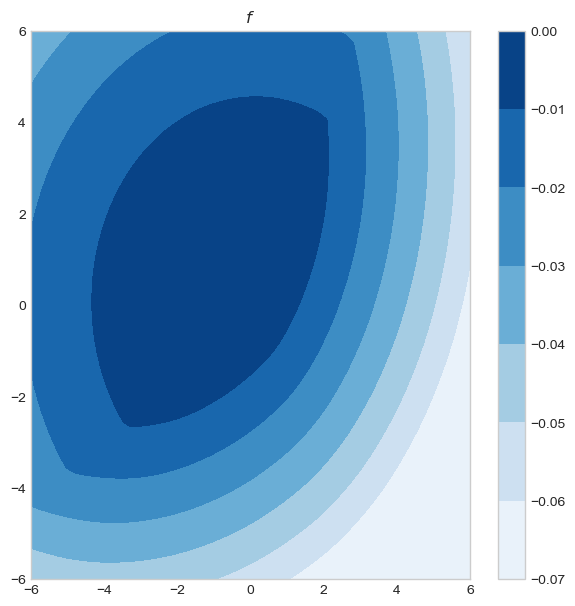

In [23]:
list_nsamples = [200, 250, 500, 750, 1000, 1500, 2000, 5000, 10000]
dict_nsamples_run_time = {}
reg_list = [1, 10, 100]
n_epochs = 10

for num_samples in list_nsamples:
    dict_run_time = {}
    rng = jax.random.PRNGKey(0)

    train_dataloaders, valid_dataloaders, input_dim, = datasets.create_gaussian_mixture_samplers(name_source="simple",
                                                                                                name_target="square_four",
                                                                                                train_batch_size=num_samples,
                                                                                                valid_batch_size=num_samples,
                                                                                                rng = rng
                                                                                                )

    X = next(train_dataloaders.source_iter)
    X_new = next(valid_dataloaders.source_iter)
    Y = next(train_dataloaders.target_iter)
    Y_new = next(valid_dataloaders.target_iter)

    #Entropic Map
    for reg in reg_list:
        start_time = time.time()
        geom = ott.geometry.pointcloud.PointCloud(X, Y, epsilon = reg)
        problem = ott.problems.linear.linear_problem.LinearProblem(geom)
        solver = ott.solvers.linear.sinkhorn.Sinkhorn()

        out = solver(problem)

        f = out.f
        g = out.g

        entropic_map = out.to_dual_potentials()
        end_time = time.time()
        run_time = end_time - start_time
        dict_run_time["Entropic OT (reg: "+str(reg)+")"] = run_time
    
    #ICNN
    optimizer_f = optax.adam(learning_rate=1e-4, b1=0.5, b2=0.9, eps=1e-8)
    optimizer_g = optax.adam(learning_rate=1e-4, b1=0.5, b2=0.9, eps=1e-8)
    neural_f = icnn.ICNN(dim_hidden=[64, 64, 64, 64], dim_data=2)
    neural_g = icnn.ICNN(dim_hidden=[64, 64, 64, 64], dim_data=2)
    num_train_iters = 2
    neural_dual_solver = neuraldual.W2NeuralDual(
        input_dim,
        neural_f,
        neural_g,
        optimizer_f,
        optimizer_g,
        num_train_iters = n_epochs
    )

    start_time = time.time()

    learned_potentials_identity = neural_dual_solver(*train_dataloaders, *valid_dataloaders)
    learned_potentials_identity.plot_potential(forward=True)

    end_time = time.time()
    dict_run_time["ICNN"] = run_time*500

    #Conditional Flow Matching
    X_tensor = torch.from_numpy(np.asarray(X))
    X_new_tensor = torch.from_numpy(np.asarray(X_new))
    Y_tensor = torch.from_numpy(np.asarray(Y))
    Y_new_tensor = torch.from_numpy(np.asarray(Y_new))

    sigma = 0.1
    dim = 2
    model = MLP(dim=dim, time_varying=True)
    optimizer = torch.optim.Adam(model.parameters())
    FM = ConditionalFlowMatcher(sigma=sigma)

    start = time.time()
    for k in range(n_epochs):
        optimizer.zero_grad()

        t, xt, ut = FM.sample_location_and_conditional_flow(X_tensor, Y_tensor)
        vt = model(torch.cat([xt, t[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer.step()

    end = time.time() 
    run_time = end - start
    dict_run_time["CFM"] = run_time*500

    #MBOT CFM
    M = torch.cdist(X_tensor, Y_tensor) ** 2

    ot_plan_list = []
    a, b = ot.unif(num_samples), ot.unif(num_samples)

    ot_sampler = OTPlanSampler(method="exact")
    pi = ot_sampler.get_map(X_tensor, Y_tensor)
    ot_plan_list.append(pi)

    batch_size_list = [128, 64]

    for i, batch_size in enumerate(batch_size_list):
        incomplete_mbot_plan = compute_incomplete_plan(X_tensor, Y_tensor, a, b, batch_size, n_epochs, M.numpy())
        ot_plan_list.append(incomplete_mbot_plan)

    sigma = 0.1
    dim = 2
    batch_size = 128

    for i, mbot_plan in enumerate(ot_plan_list):
        model = MLP(dim=dim, time_varying=True)
        optimizer = torch.optim.Adam(model.parameters())
        FM = ConditionalFlowMatcher(sigma=sigma)

        ot_sampler = OTPlanSampler(method="exact")

        start = time.time()
        for k in range(n_epochs):
            optimizer.zero_grad()

            indices_i, indices_j = ot_sampler.sample_map(
                mbot_plan, batch_size=batch_size, replace=False
            )
            batch_x0, batch_x1 = X_tensor[indices_i], Y_tensor[indices_j]

            t, xt, ut = FM.sample_location_and_conditional_flow(batch_x0, batch_x1)

            vt = model(torch.cat([xt, t[:, None]], dim=-1))
            loss = torch.mean((vt - ut) ** 2)

            loss.backward()
            optimizer.step()
        end = time.time()
        run_time = end - start
        if i == 0:
            dict_run_time["OT-CFM trained with true OT plan"] = run_time*500
        else:
            dict_run_time["OT-CFM trained w. MBOT (size:"+str(batch_size)+")"] = run_time*500
    
    #SB-CFM
    ot_plan_list = []
    for i, reg in enumerate(reg_list):
        ot_sampler = OTPlanSampler(method="sinkhorn", reg=reg)
        entropic_ot_plan = ot_sampler.get_map(X_tensor, Y_tensor)
        ot_plan_list.append(entropic_ot_plan)
    
    sigma = 0.1
    dim = 2
    batch_size = 128

    for i, reg in enumerate(reg_list):
        model = MLP(dim=dim, time_varying=True)
        optimizer = torch.optim.Adam(model.parameters())
        FM = ConditionalFlowMatcher(sigma=sigma)

        ot_sampler = OTPlanSampler(method="sinkhorn", reg=reg)

        pi = ot_sampler.get_map(X_tensor, Y_tensor)

        start = time.time()
        for k in range(n_epochs):
            optimizer.zero_grad()

            indices_i, indices_j = ot_sampler.sample_map(pi, batch_size=batch_size, replace=False)
            batch_x0, batch_x1 = X_tensor[indices_i], Y_tensor[indices_j]

            t, xt, ut = FM.sample_location_and_conditional_flow(batch_x0, batch_x1)

            vt = model(torch.cat([xt, t[:, None]], dim=-1))
            loss = torch.mean((vt - ut) ** 2)

            loss.backward()
            optimizer.step()
        end = time.time()
        run_time = end - start
        dict_run_time["SB-CFM  (reg:"+str(reg)+")"] = run_time*500

    dict_nsamples_run_time[num_samples] = dict_run_time

df_nsamples_run_time = pd.DataFrame(dict_nsamples_run_time).T
df_nsamples_run_time.index.name = 'n'
clear_output()

C:\Users\yanis\AppData\Local\Temp\ipykernel_144012\4058043152.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


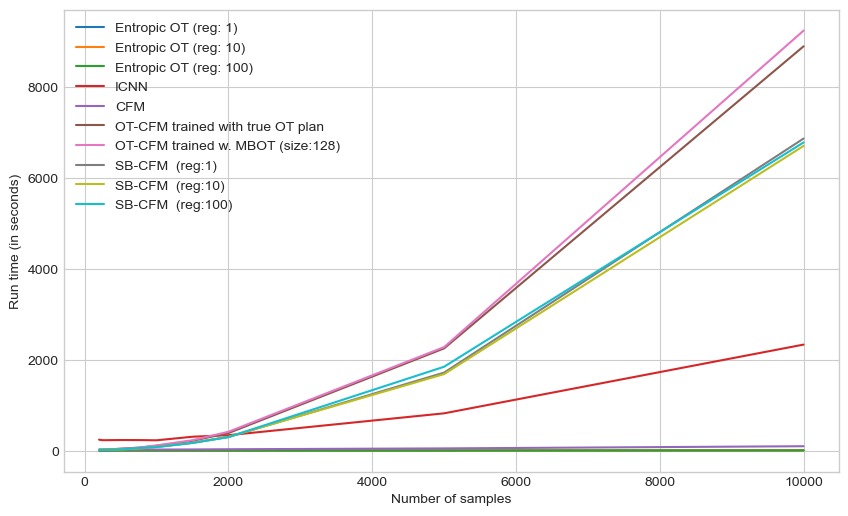

In [26]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 6))
df_nsamples_run_time.plot(ax=plt.gca())
plt.xlabel('Number of samples')
plt.ylabel('Run time (in seconds)')
plt.legend()
plt.grid(True)
plt.show()